In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
%matplotlib inline

/Users/guaisang/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/guaisang/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Load the data

In [69]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,restaurant,location,star,price,rating,cuisine,review_count
0,Pleasant+House,1,0,2,4.5,Bakeries,489
1,Publican+Quality+Meats,1,0,2,4.5,Butcher,478
2,La+Sirena+Clandestina,1,0,2,4.0,Latin American,350
3,Arami,1,0,3,4.0,Sushi Bars,522
4,Green+Zebra,1,0,3,4.0,Vegetarian,917


In [4]:
df.dtypes

restaurant       object
location          int64
star              int64
price             int64
rating          float64
cuisine          object
review_count      int64
dtype: object

In [5]:
# Create categorical feature

le = LabelEncoder()
df.cuisine = le.fit_transform(df.cuisine)

In [6]:
# define X and y. Only four features available, so I chose not to select features

X = df[['price', 'rating', 'cuisine', 'review_count']]
y = df.star

In [7]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df.star, random_state=7)

### EDA

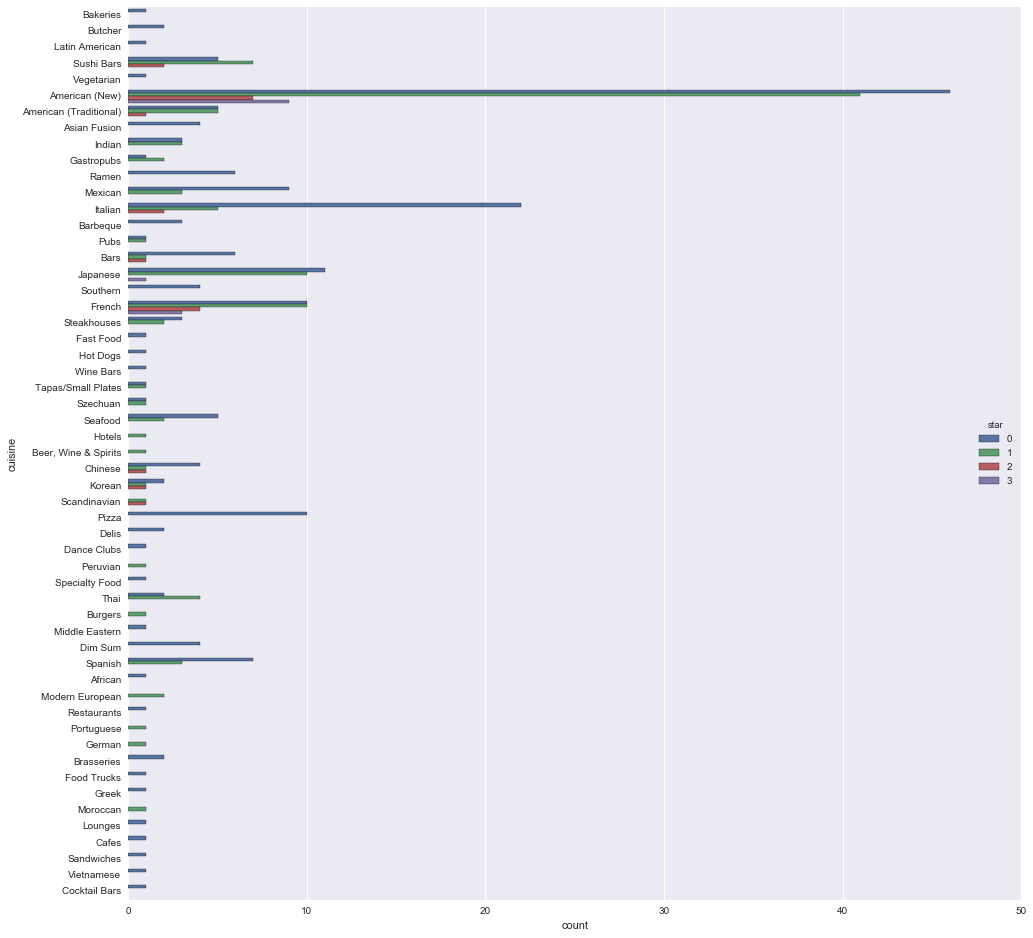

In [93]:
sns.set(style="darkgrid")
plt.figure(figsize=(16,16))
sns.countplot(y=df.cuisine, hue=df.star)

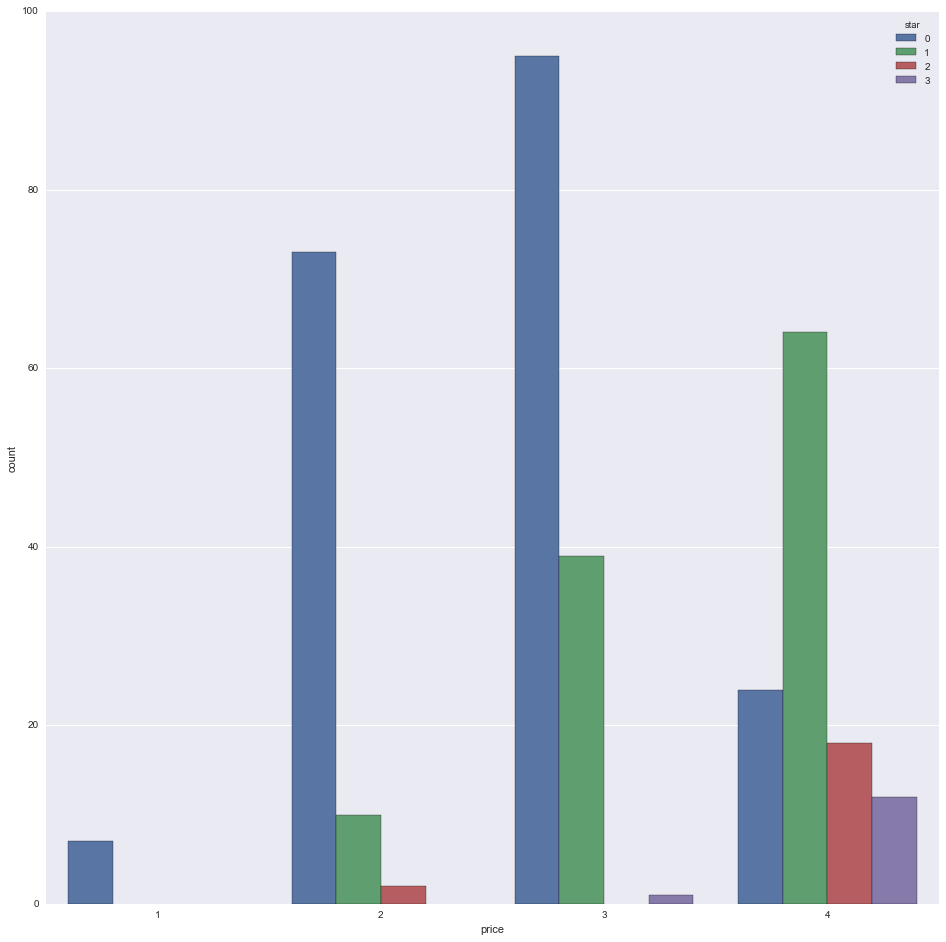

In [94]:
sns.set(style="darkgrid")
plt.figure(figsize=(16,16))
sns.countplot(x='price', hue='star', data=df)

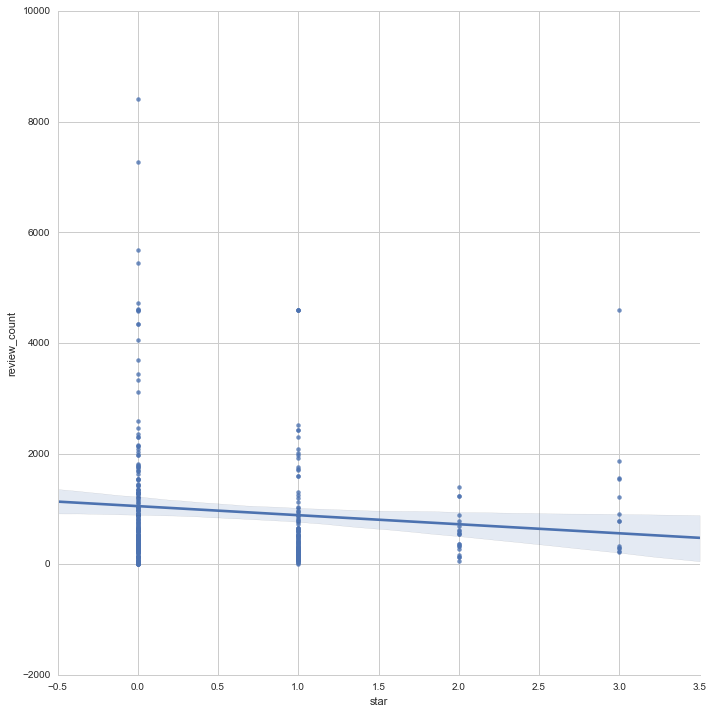

In [92]:
sns.set_style('whitegrid')
sns.lmplot(x='star', y='review_count', data=df, size=10)

### Define functions to optimize, fit and evaluate models

In [8]:
# Define grid search function to optimize F1 score. 
# Why F1 score, not accuracy score? Because the classes are unbalanced,
# by only guessing 0 may generate a good accuracy score, but it's meaningless

def gridsearch(model, params):
    gs = GridSearchCV(model, params, scoring='f1_weighted', n_jobs=-1)
    gs.fit(X_train, y_train)
    print 'best parameters: ', gs.best_params_
    print 'cross validation F1 score on trainset: ', gs.best_score_
    print 'F1 score on testset: ', gs.score(X_test, y_test)

In [9]:
# Define function to check the accuracy score and make prediction

def validation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print 'accuracy score on testset: ', model.score(X_test, y_test)
    return y_pred

In [10]:
# Define function to evaluate models based on the scoring matrix of the competition

dist = stats.norm(len(y_test[y_test!=0]), len(y_test[y_test!=0]))
def evaluation(pred):
    height=0
    for i in zip(pred, y_test):
        if i[0]!=0 and i[1]!=0:
            if i[0] == i[1]:
                height+=dist.pdf(len(pred[pred!=0]))*1.5
            else:
                height+=dist.pdf(len(pred[pred!=0]))
    return height

In [11]:
# Define function to produce confusion matrix

def make_confusion(pred):
    conmat = np.array(confusion_matrix(y_test, pred, labels=[3,2,1,0]))
    confusion = pd.DataFrame(conmat, index=['3 stars', '2 stars', '1 star', 'no star'], 
                             columns=['pred 3', 'pred 2', 'pred 1', 'pred no'])
    print confusion

In [12]:
# Define function to produce ROC curve

def plot_roc(model):
    y_score = model.predict_proba(X_test)
    fpr = {}
    tpr = {}
    roc_auc = {}
    labels = []
    plt.figure(figsize=[11,9])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic', fontsize=18)
    for i in range(y_score.shape[1]):
        stars = i
        fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:,i], pos_label=stars)
        roc_auc[i] = auc(fpr[i], tpr[i])
        labels.append(stars)
        plt.plot(fpr[i], tpr[i], label='roc for {} (area={})'.format(stars, roc_auc[i]), linewidth=4)
    plt.legend(loc="lower right")
    plt.show()

### Random Forest

In [13]:
# Grid search to find the best parameters

rf = RandomForestClassifier(n_jobs=-1)
rf_params = {'n_estimators': [5,10,15,20,30], 'criterion': ['gini', 'entropy'], 
            'max_features': ['auto', None], 'max_depth': [3,5,10,None]}
gridsearch(rf, rf_params)

/Users/guaisang/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guaisang/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guaisang/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guaisang/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


best parameters:  {'max_features': None, 'n_estimators': 15, 'criterion': 'entropy', 'max_depth': 3}
cross validation F1 score on trainset:  0.673661517604
F1 score on testset:  0.623916530092


/Users/guaisang/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:426: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)
/Users/guaisang/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
# Use the best parameters to test on testset

rf = RandomForestClassifier(max_features=None, n_estimators=15, criterion='entropy', max_depth=3, n_jobs=-1)
rf_pred = validation(rf)

accuracy score on testset:  0.692307692308


In [15]:
# evaluate model performance

evaluation(rf_pred)

0.3548269703202388

In [16]:
# Confusion matrix
# Overall doing pretty well in identifying starred restaurants, but failed to recognize any 2 or 3 star restaurants.

make_confusion(rf_pred)

         pred 3  pred 2  pred 1  pred no
3 stars       0       0       4        0
2 stars       0       0       4        2
1 star        0       0      21       13
no star       0       0       9       51


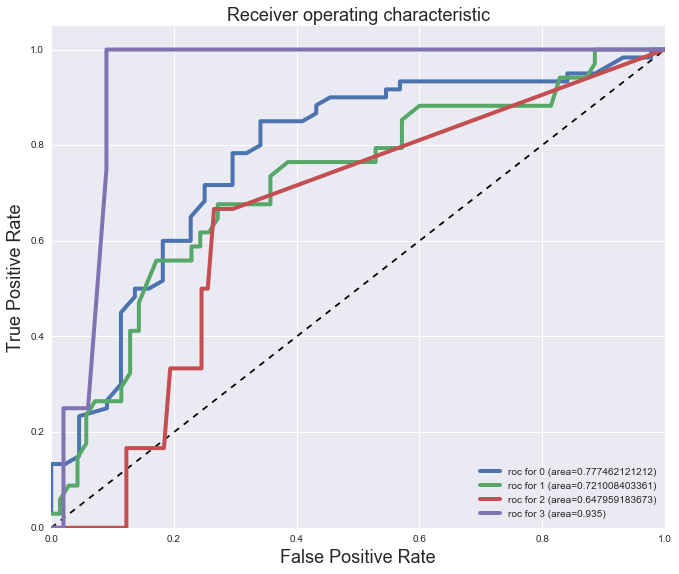

In [17]:
# ROC curve for Random Forest

plot_roc(rf)

In [18]:
# Fit the whole dataset to get as much information as pissible

rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Boosting

In [19]:
gbc = GradientBoostingClassifier()
gbc_params = {'n_estimators': [50, 100, 150, 200, 300], 'max_depth': [3,5,10,None], 'max_features': ['auto', None]}
gridsearch(gbc, gbc_params)

best parameters:  {'max_features': 'auto', 'n_estimators': 50, 'max_depth': 3}
cross validation F1 score on trainset:  0.63347872513
F1 score on testset:  0.591213227683


In [20]:
gbc = GradientBoostingClassifier(max_features='auto', n_estimators=50, max_depth=3)
gbc_pred = validation(gbc)

accuracy score on testset:  0.605769230769


In [21]:
evaluation(gbc_pred)

0.3260702967958537

In [22]:
# Confusion matrix
# Doing well in identifying 3 stars, at the mean time miss classify a lot 3 stars

make_confusion(gbc_pred)

         pred 3  pred 2  pred 1  pred no
3 stars       3       0       1        0
2 stars       1       0       3        2
1 star        4       0      15       15
no star       0       1      14       45


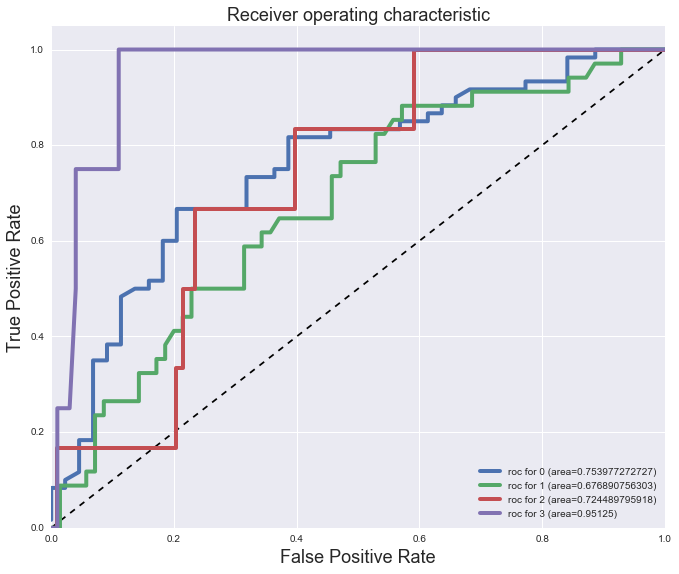

In [23]:
# ROC curve for Random Forest

plot_roc(gbc)

In [24]:
gbc.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=50, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

### SVM

In [25]:
# cuisine as a categorical feature should have been converted to dummy variables.
# However, the number of categories in the training set is different from testing set, 
# which brings difficulty to apply the model on the testing set, so here I had to treat it as a numerical feature.

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df.star, random_state=7)

In [31]:
sv = svm.SVC(kernel = 'rbf')
sv_params = {'C':10.**np.arange(-2, 3), 'gamma':10.**np.arange(-5, 2)}
gridsearch(sv, sv_params)

best parameters:  {'C': 10.0, 'gamma': 0.01}
cross validation F1 score on trainset:  0.668422900818
F1 score on testset:  0.623916530092


In [32]:
sv = svm.SVC(C=10, gamma=0.01, probability=True)
sv_pred = validation(sv)

accuracy score on testset:  0.663461538462


In [33]:
evaluation(sv_pred)

0.29439504347489648

In [34]:
# good at identify non starred restaurants
make_confusion(sv_pred)

         pred 3  pred 2  pred 1  pred no
3 stars       0       0       4        0
2 stars       0       0       4        2
1 star        0       0      17       17
no star       0       0       8       52


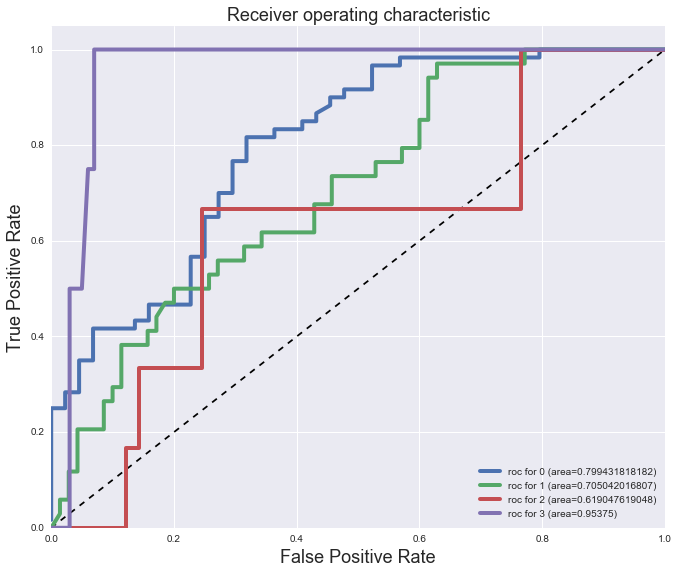

In [35]:
plot_roc(sv)

In [36]:
sv.fit(X, y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Neural Network

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

Using Theano backend.


In [38]:
xs = X.astype(float)
ys = np_utils.to_categorical(y)

In [39]:
xs.shape

(345, 4)

In [40]:
# define the neural network

def baseline_model():
    model = Sequential()
    model.add(Dense(8, input_dim=4, init='normal', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [41]:
xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.3, stratify=df.star, random_state=7)

In [42]:
# the neural network failed to predict positive (non zero classes) with sigmoid function in output layer.
# So I switched it to softmax. 
# If adding class_weight into the model, the scoring matrix would be much better. 
# However, the accuracy score dropped dramatically. So I ended up leaving it as it was

nn = KerasClassifier(build_fn=baseline_model, nb_epoch=200, batch_size=20, verbose=0)

In [43]:
print cross_val_score(nn, xs_train, ys_train, cv=5, n_jobs=-1).mean()
nn.fit(xs_train, ys_train)
nn_pred = nn.predict(xs_test)

0.697193877794


In [44]:
evaluation(nn_pred)

0.29439504347489648

In [45]:
# The confusion matrix is exactly same as SVM, which is very interesting
make_confusion(nn_pred)

         pred 3  pred 2  pred 1  pred no
3 stars       0       0       4        0
2 stars       0       0       4        2
1 star        0       0      17       17
no star       0       0       8       52


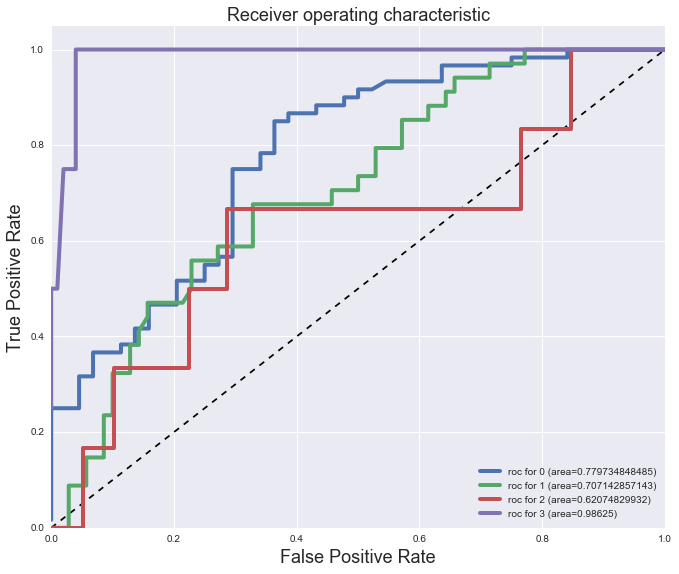

In [46]:
# plot roc curve for neural network
plot_roc(nn)

In [47]:
nn.fit(xs, ys)

### Make prediction

In [48]:
# load the test data

dc = pd.read_csv('dc.csv')

In [49]:
# create the categorical feature of cuisine type

dc.cuisine = le.fit_transform(dc.cuisine)

In [50]:
# make prediction with random forest and boosting

X_dc = dc[['price', 'rating', 'cuisine', 'review_count']]
dc_rf = rf.predict(X_dc)
dc_gbc = gbc.predict(X_dc)

In [51]:
# add predictions into dataframe

dc['rf_pred'] = dc_rf
dc['gbc_pred'] = dc_gbc

In [52]:
# standardize features and make prediction with svm

X_dc = scaler.fit_transform(X_dc)
dc_sv = sv.predict(X_dc)
dc['sv_pred'] = dc_sv

In [53]:
# make prediction with neural network

dc_nn = nn.predict(X_dc)
dc['nn_pred'] = dc_nn

In [58]:
# create the prediction dataframe

dc_prediction = dc[['restaurant', 'rf_pred', 'gbc_pred', 'sv_pred', 'nn_pred']]

In [59]:
# save the dataframe into csv file and pick final list manually.

dc_prediction.to_csv('dc_prediction.csv', index=False)

Since no model performs exceptionally well, I determined the final prediction by majority vote. That is, only restaurants that are predicted by 3 or more models will be included. See ChengJi-submission.csv for final list.